# ASLive Sign2Text Model

This notebook implements the sign language to text model following the architecture:
- **Vision Layer (CNN)**: Extracts spatial features from each frame
- **Positional Encoding (PE)**: Adds temporal position information
- **Attention Layer (LSTM)**: Processes temporal sequence with attention
- **FC Layer**: Final classification layer


In [ ]:
!pip install kagglehub torchcodec torchvision
!pip install git+https://github.com/facebookresearch/pytorchvideo

In [10]:
# Before running, add everything from SQ_dataloader.ipynb into the cell below and run

## 1. Data Loading (from SQ_dataloader)


In [2]:
#add SQ_dataloader code here
from torch.utils.data import Dataset
from torchvision import transforms
from torchcodec.decoders import VideoDecoder
import kagglehub
import os
import json

import torch # Assuming torch is imported elsewhere
from torch.utils.data import Dataset
from torchvision import transforms
from torchcodec.decoders import VideoDecoder
import kagglehub
import os
import json
from PIL import Image # Needed for cropping if working with PIL images

class WLASLTorchCodec(Dataset):
  download_path = None

  def __init__(self, json_path=None, video_dir=None, download=True, max_classes=None, split="train", num_frames=32, transform=None, sample_transform=None):
    print("Will download:", download)
    if (json_path is None or video_dir is None) and download == False:
      raise ValueError("json_path and video_dir must be provided with download false")
    if download:
      if WLASLTorchCodec.download_path is None:
        path = kagglehub.dataset_download("sttaseen/wlasl2000-resized")
        WLASLTorchCodec.download_path = path
      else:
        path = WLASLTorchCodec.download_path
      print("Downloaded at path: ", path)

      self.video_dir = os.path.join(path, "wlasl-complete", "videos")
      json_path = os.path.join(path, "wlasl-complete","WLASL_v0.3.json")
      downloaded = True
    else:
      self.video_dir = video_dir
    self.num_frames = num_frames
    self.transform = transform
    self.sample_transform = sample_transform

    # Read json
    with open(json_path, "r") as f:
      data = json.load(f)
    if max_classes is not None:
        if isinstance(max_classes, int):
            # Keep only the first N entries (Usually the most frequent in WLASL)
            data = data[:max_classes]
            print(f"Limiting dataset to top {max_classes} classes.")
        elif isinstance(max_classes, list):
            # Keep only entries that match specific glosses
            data = [entry for entry in data if entry['gloss'] in max_classes]
            print(f"Limiting dataset to {len(data)} specific classes.")
    self.samples = []
    self.label_map = {}
    label_id = 0

    for entry in data:
      gloss = entry["gloss"]

      if gloss not in self.label_map:
        self.label_map[gloss] = label_id
        label_id += 1

      label = self.label_map[gloss]

      for inst in entry["instances"]:
        if inst["split"] != split:
          continue

        video_id = inst["video_id"]
        file_path = os.path.join(self.video_dir, f"{video_id}.mp4")

        # 1. Modification in __init__: Extract and store frame/bbox info
        frame_start = inst.get("frame_start", 1) # Default to 1 if missing
        frame_end = inst.get("frame_end", -1)   # Default to -1 if missing
        bbox = inst.get("bbox", [0, 0, 1.0, 1.0]) # Default to normalized full frame if missing

        if os.path.isfile(file_path):
          # Store a tuple of (file_path, label, frame_start, frame_end, bbox)
          self.samples.append((file_path, label, frame_start, frame_end, bbox))
        self.num_classes = label_id
  def __len__(self):
    return len(self.samples)

  def __getitem__(self, idx):
    # 2. Modification in __getitem__: Unpack all instance info
    video_path, label, frame_start, frame_end, bbox = self.samples[idx]

    # Convert WLASL 1-based indices (inclusive start, exclusive end) to
    # torchcodec's 0-based indices (inclusive start, inclusive end).

    decoder = VideoDecoder(video_path)
    video_length = decoder.metadata.num_frames
    end_frame = frame_end - 1 if frame_end > 0 else video_length
    start_frame = 0
    if end_frame > video_length:
      end_frame = video_length
    else:
      end_frame = frame_end - 2 if frame_end > 0 else None
    if frame_start > video_length:
      start_frame = 0
    else:
      start_frame = frame_start - 1
    frames = None
    if self.sample_transform is None:
      import torchcodec.samplers as samplers
      frames = samplers.clips_at_regular_indices(decoder, num_frames_per_clip=self.num_frames, sampling_range_start=start_frame, sampling_range_end=end_frame).data[0]
    else:
      frames = self.sample_transform(decoder)
    if self.transform:
      # Transform should handle T x C x H x W input
      frames = self.transform(frames)
    return frames, torch.tensor(label) # Ensure label is a tensor

Will download: True
Using Colab cache for faster access to the 'wlasl2000-resized' dataset.
Downloaded at path:  /kaggle/input/wlasl2000-resized
Limiting dataset to top 1 classes.


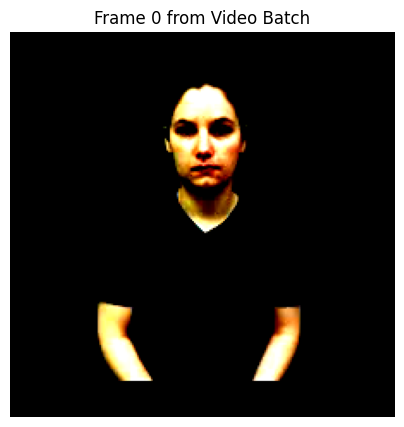

In [3]:
import pytorchvideo.transforms as ptv_transforms
from torchvision.transforms import Compose, Lambda


mean = [0.45, 0.45, 0.45]
std = [0.225, 0.225, 0.225]

# Test out dataset
train_transform = Compose(
    [
        ptv_transforms.ConvertUint8ToFloat(),
        Lambda(lambda x: x.permute(1, 0, 2, 3)),
        ptv_transforms.Normalize(mean, std),
        Lambda(lambda x: x.permute(1, 0, 2, 3)),
        ptv_transforms.ShortSideScale(size=224),
    ]
)

def show_frame(video, frame_idx):
  import matplotlib.pyplot as plt
  import numpy as np
  single_frame = video[frame_idx]
  frame_np = single_frame.detach().cpu().numpy()

  frame_np = np.transpose(frame_np, (1, 2, 0))
  plt.figure(figsize=(5, 5))
  plt.imshow(frame_np)
  plt.title(f'Frame {frame_idx} from Video Batch')
  plt.axis('off') # Hide axis ticks and labels
  plt.show()


dataset = WLASLTorchCodec(max_classes=1, transform=train_transform)
video, _ = dataset[0]
show_frame(video, 0)

## 2. Vision Layer (CNN Backbone)

The Vision Layer extracts spatial features from each video frame using a CNN. We use a pretrained ResNet-18 as the backbone and remove the final classification layer to get feature embeddings.


In [4]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class VisionLayer(nn.Module):
    """CNN backbone for extracting spatial features from video frames.

    Uses pretrained ResNet-18 as feature extractor.
    Input: (batch, T, C, H, W) - batch of T frames
    Output: (batch, T, feature_dim) - feature vectors for each frame
    """

    def __init__(self, feature_dim=512, pretrained=True, freeze_backbone=False):
        super(VisionLayer, self).__init__()

        # Load pretrained ResNet-18
        resnet = models.resnet18(weights='IMAGENET1K_V1' if pretrained else None)

        # Remove the final FC layer
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])

        # ResNet-18 outputs 512-dim features
        self.resnet_feature_dim = 512

        # Optional projection layer to adjust feature dimension
        if feature_dim != self.resnet_feature_dim:
            self.projection = nn.Linear(self.resnet_feature_dim, feature_dim)
        else:
            self.projection = None

        self.feature_dim = feature_dim

        # Freeze backbone if specified
        self.set_freeze_backbone(freeze_backbone)

    def set_freeze_backbone(self, is_frozen):
      for param in self.backbone.parameters():
          param.requires_grad = not is_frozen

    def forward(self, x):
        """
        Args:
            x: Input tensor of shape (batch, T, C, H, W)
        Returns:
            Feature tensor of shape (batch, T, feature_dim)
        """
        batch_size, T, C, H, W = x.shape

        # Reshape to process all frames together: (batch * T, C, H, W)
        x = x.view(batch_size * T, C, H, W)
        features = self.backbone(x)
        features = features.view(batch_size * T, -1)
        if self.projection is not None:
            features = self.projection(features)
        features = features.view(batch_size, T, self.feature_dim)

        return features


## 3. Attention Layer (LSTM with Attention)

Bidirectional LSTM processes the sequence of frame features, followed by an attention mechanism to weight the importance of different time steps.


In [13]:
import math
class Attention(nn.Module):
    """Attention mechanism for weighting LSTM outputs.

    Computes attention weights over the sequence and returns a weighted sum.
    """

    def __init__(self, hidden_dim):
        super(Attention, self).__init__()

        self.attention = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.Tanh(),
            nn.Linear(hidden_dim // 2, 1)
        )

    def forward(self, lstm_output):
        """
        Args:
            lstm_output: LSTM outputs of shape (batch, T, hidden_dim)
        Returns:
            context: Weighted sum of shape (batch, hidden_dim)
            attention_weights: Attention weights of shape (batch, T)
        """
        # Compute attention scores: (batch, T, 1)
        scores = self.attention(lstm_output)
        attention_weights = F.softmax(scores, dim=1)
        context = torch.sum(attention_weights * lstm_output, dim=1)

        return context, attention_weights.squeeze(-1)


class AttentionLSTM(nn.Module):
    """Bidirectional LSTM with attention mechanism.

    Processes temporal sequence of frame features and outputs a fixed-size representation.
    """

    def __init__(self, input_dim, hidden_dim=256, num_layers=2, dropout=0.3, bidirectional=True):
        super(AttentionLSTM, self).__init__()

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1

        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=bidirectional
        )

        # Attention mechanism
        self.attention = Attention(hidden_dim * self.num_directions)

        # Output dimension
        self.output_dim = hidden_dim * self.num_directions

    def forward(self, x):
        """
        Args:
            x: Input tensor of shape (batch, T, input_dim)
        Returns:
            output: Context vector of shape (batch, hidden_dim * num_directions)
            attention_weights: Attention weights of shape (batch, T)
        """
        lstm_output, (hidden, cell) = self.lstm(x)
        context, attention_weights = self.attention(lstm_output)

        return context, attention_weights


class PositionalEncoding(nn.Module):
    """Sinusoidal positional encoding for temporal sequences.

    Adds position information to help the model understand the order of frames.
    """

    def __init__(self, d_model, max_len=500, dropout=0.1):
        super(PositionalEncoding, self).__init__()

        # self.dropout = nn.Dropout(p=dropout)

        # Create positional encoding matrix
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # Add batch dimension: (1, max_len, d_model)
        pe = pe.unsqueeze(0)

        # Register as buffer (not a parameter, but should be saved/loaded)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: Input tensor of shape (batch, T, d_model)
        Returns:
            Tensor with positional encoding added: (batch, T, d_model)
        """
        x = x + self.pe[:, :x.size(1), :]
        return x


## 5. Complete Sign2Text Model

Combines all components: Vision Layer → Positional Encoding → Attention LSTM → FC Layer → Classification


In [14]:
class Sign2TextModel(nn.Module):
    """Complete Sign Language to Text model.

    Architecture:
    1. Vision Layer (CNN): Extract spatial features from each frame
    2. Positional Encoding: Add temporal position information
    3. Attention LSTM: Process temporal sequence with attention
    4. FC Layer: Final classification
    """

    def __init__(self, num_classes, feature_dim=512, hidden_dim=256,
                 num_lstm_layers=2, dropout=0.3, pretrained_cnn=True,
                 classification_layers=(256,),
                 freeze_cnn=False, max_frames=100):
        super(Sign2TextModel, self).__init__()

        # Vision Layer (CNN)
        self.vision_layer = VisionLayer(
            feature_dim=feature_dim,
            pretrained=pretrained_cnn,
            freeze_backbone=freeze_cnn
        )
        # Attention Layer (LSTM)
        self.attention_lstm = AttentionLSTM(
            input_dim=feature_dim,
            hidden_dim=hidden_dim,
            num_layers=num_lstm_layers,
            dropout=dropout,
            bidirectional=True
        )

        # Positional Encoding
        self.positional_encoding = PositionalEncoding(
            d_model=feature_dim,
            max_len=100,
            dropout=dropout
        )

        layers = []
        self.lstm_ln = nn.LayerNorm(hidden_dim * 2)
        input_dim = self.attention_lstm.output_dim
        for i, dim in enumerate(classification_layers):
            layers.append(nn.Linear(input_dim, dim))
            layers.append(nn.BatchNorm1d(dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            input_dim = dim

        layers.append(nn.Linear(input_dim, num_classes))
        # FC Layer (Classification)
        self.fc_layer = nn.Sequential(
            *layers
        )

        self.num_classes = num_classes

        self._init_weights()

    def set_freeze(self, is_frozen):
        self.vision_layer.set_freeze_backbone(is_frozen)

    def forward(self, x, return_attention=False):
        """
        Args:
            x: Input video frames of shape (batch, T, C, H, W)
            return_attention: If True, also return attention weights
        Returns:
            logits: Classification logits of shape (batch, num_classes)
            attention_weights (optional): Attention weights of shape (batch, T)
        """
        # Vision Layer: (batch, T, C, H, W) → (batch, T, feature_dim)
        features = self.vision_layer(x)
        features = self.positional_encoding(features)
        # Attention LSTM: (batch, T, feature_dim) → (batch, hidden_dim * 2)
        context, attention_weights = self.attention_lstm(features)

        # FC Layer: (batch, hidden_dim * 2) → (batch, num_classes)
        logits = self.fc_layer(context)

        if return_attention:
            return logits, attention_weights
        return logits

    def _init_weights(self):
        """Applies Xavier initialization to Linear layers and LSTM weights."""

        # Initialize LSTM weights
        # For LSTMs, orthogonal initialization for recurrent weights and Xavier for input weights is common.
        # However, nn.init.xavier_uniform_ is a good general starting point.
        for name, param in self.attention_lstm.named_parameters():
            if 'weight' in name:
                # Apply Xavier/Glorot for weights
                nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                # Initialize biases to zero (or use a specific trick like setting forget gate bias to 1)
                nn.init.constant_(param, 0.0)

        # Initialize Classification FC Layers
        for m in self.fc_layer.modules():
            if isinstance(m, nn.Linear):
                # Use Xavier/Glorot for weights
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)

## 6. Training Utilities


In [15]:
from torch.amp import autocast, GradScaler
from tqdm import tqdm

scaler = GradScaler()

def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train the model for one epoch."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(dataloader, desc="Training")
    for frames, labels in progress_bar:
        frames = frames.to(device)
        labels = labels.to(device)
        # print(frames.shape)
        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        with autocast('cuda'):
          outputs = model(frames)
          loss = criterion(outputs, labels)
        # Backward pass

        scaler.scale(loss).backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        scaler.step(optimizer)
        scaler.update()
        # loss.backward()
        # optimizer.step()

        # Statistics
        running_loss += loss.item() * frames.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        progress_bar.set_postfix({
            'loss': loss.item(),
            'acc': 100 * correct / total
        })

    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total

    return epoch_loss, epoch_acc


def evaluate(model, dataloader, criterion, device):
    """Evaluate the model on a dataset."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for frames, labels in tqdm(dataloader, desc="Evaluating"):
            frames = frames.to(device)
            labels = labels.to(device)

            with autocast('cuda'):
                outputs = model(frames)
                loss = criterion(outputs, labels)

            running_loss += loss.item() * frames.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total

    return epoch_loss, epoch_acc


## 7. Configuration and Setup


In [16]:
# ============================================
# CONFIGURATION - Modify these paths and hyperparameters
# ============================================

# Data paths
JSON_PATH = "/content/drive/MyDrive/wlasl_resized/wlasl-complete/WLASL_v0.3.json"  # Path to WLASL JSON
VIDEO_DIR = "/content/drive/MyDrive/wlasl_resized/wlasl-complete/videos"  # Path to video directory

# Model hyperparameters
NUM_FRAMES = 24           # Number of frames to sample from each video
FEATURE_DIM = 512        # CNN feature dimension
HIDDEN_DIM = 128         # LSTM hidden dimension
NUM_LSTM_LAYERS = 2      # Number of LSTM layers
DROPOUT = 0.0            # Dropout rate
EPOCHS_UNTIL_UNFREEZE = 50
FREEZE_CNN = True       # Whether to freeze CNN backbone
PRETRAINED_CNN = True    # Use pretrained CNN weights

# Training hyperparameters
BATCH_SIZE = 32           # Batch size (adjust based on GPU memory)
LEARNING_RATE = 1e-3     # Learning rate
NUM_EPOCHS = 200          # Number of training epochs
WEIGHT_DECAY = 1e-4     # L2 regularization
IMG_SIZE=224
# Loader Options
WORKERS = 8

PREFETCH = 4

In [17]:
from torchvision.transforms import v2
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Lambda
import pytorchvideo.transforms as ptv_transforms
from pytorchvideo.transforms import functional as ptv_functional

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import tv_tensors

mean = [0.45, 0.45, 0.45]
std = [0.225, 0.225, 0.225]

# Test out dataset
# Normalize using Resnet means
train_transform = Compose(
    [
        ptv_transforms.ConvertUint8ToFloat(),
        ptv_transforms.ShortSideScale(size=IMG_SIZE),
        Lambda(lambda x: x.permute(1, 0, 2, 3)),
        ptv_transforms.Normalize(mean, std),
        Lambda(lambda x: x.permute(1, 0, 2, 3)),
        ptv_transforms.RandAugment(magnitude=9, num_layers=2, prob=0.6),
    ]
)

test_transform = Compose(
    [
        ptv_transforms.ConvertUint8ToFloat(),
        ptv_transforms.ShortSideScale(size=IMG_SIZE),
        Lambda(lambda x: x.permute(1, 0, 2, 3)),
        ptv_transforms.Normalize(mean, std),
        Lambda(lambda x: x.permute(1, 0, 2, 3)),
    ]
)
val_transform =test_transform

In [18]:
def train_val_test_split(batch_size=20, workers=WORKERS, prefetch_factor=0.5, classes=100, frames=NUM_FRAMES):
  # Create datasets
  train_dataset = WLASLTorchCodec(
      download=True,
      split="train",
      max_classes=classes,
      num_frames=frames,
      transform=train_transform
  )

  val_dataset = WLASLTorchCodec(
      download=True,
      split="val",
      max_classes=classes,
      num_frames=frames,
      transform=val_transform
  )

  test_dataset = WLASLTorchCodec(
      download=True,
      split="test",
      max_classes=classes,
      num_frames=frames,
      transform=test_transform
  )

  print(f"Number of training samples: {len(train_dataset)}")
  print(f"Number of validation samples: {len(val_dataset)}")
  print(f"Number of test samples: {len(test_dataset)}")
  print(f"Number of classes: {classes}")

  # Create data loaders
  train_loader = DataLoader(
      train_dataset,
      batch_size=batch_size,
      shuffle=True,
      num_workers=workers,           # Start high. The optimal value is often 4 to 12.
      pin_memory=True,         # Accelerates the transfer of data from CPU to GPU VRAM.
      persistent_workers=True, # Recommended for PyTorch multi-process workers to save epoch setup time.
      prefetch_factor=int(workers*prefetch_factor)
  )

  val_loader = DataLoader(
      val_dataset,
      batch_size=batch_size,
      shuffle=False,
      num_workers=WORKERS,           # Start high. The optimal value is often 4 to 12.
                              # Since video decoding is CPU-heavy, 8 is a good starting point.
      pin_memory=True,         # Accelerates the transfer of data from CPU to GPU VRAM.
      persistent_workers=True, # Recommended for PyTorch multi-process workers to save epoch setup time.
      prefetch_factor=int(workers*prefetch_factor)
  )

  test_loader = DataLoader(
      test_dataset,
      batch_size=batch_size,
      shuffle=False,
      num_workers=WORKERS,           # Start high. The optimal value is often 4 to 12.
      pin_memory=True,         # Accelerates the transfer of data from CPU to GPU VRAM.
      persistent_workers=True, # Recommended for PyTorch multi-process workers to save epoch setup time.
      prefetch_factor=int(workers*prefetch_factor)
  )
  return train_loader, val_loader, test_loader

In [19]:
# Base usage of the model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
CLASSES_COUNT = 10

model = Sign2TextModel(
    num_classes=CLASSES_COUNT,
    feature_dim=FEATURE_DIM,
    hidden_dim=HIDDEN_DIM,
    num_lstm_layers=NUM_LSTM_LAYERS,
    dropout=DROPOUT,
    pretrained_cnn=PRETRAINED_CNN,
    freeze_cnn=FREEZE_CNN,
    max_frames=NUM_FRAMES,
    classification_layers=(16,)
).to(device)

print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")


Using device: cuda

Total parameters: 12,267,035
Trainable parameters: 1,090,523


## 8. Training Loop


In [20]:
from typing import *
import os
# Set device
import time
import torch
torch.cuda.empty_cache()

from torch.utils.tensorboard import SummaryWriter
FOLDER_PATH = "/content/drive/MyDrive/Intro_2_DL"
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
def train_model(model,
                train_loader,
                val_loader,
                classes,
                freeze=FREEZE_CNN,
                num_epochs=NUM_EPOCHS,
                epochs_until_unfreeze=EPOCHS_UNTIL_UNFREEZE,
                model_path="2d_cnn_lstm_wlasl{classes}_{tag}.pth",
                tag="v1",
                cont=True
  ):
  MODEL_NAME = model_path.format(classes=classes, tag=tag)
  MODEL_PATH = os.path.join(FOLDER_PATH, MODEL_NAME)
  print("Output: ", MODEL_PATH)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.AdamW( model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY )
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( optimizer, mode='min', factor=0.8, patience=5 )
  best_val_acc = 0.0
  start_epoch = 0
  try:
    if cont:
        checkpoint = torch.load(model_path)
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        model.load_state_dict(checkpoint['model_state_dict'])
        val_acc.extend(checkpoint['val_acc'])
  except:
    pass

  LOG_DIR = os.path.join(FOLDER_PATH, "runs", f"experiment_wlasl{CLASSES_COUNT}")
  writer = SummaryWriter(log_dir=LOG_DIR)
  history = {
      'train_loss': []
      , 'train_acc': []
      , 'val_loss': []
      , 'val_acc': []
  }

  for epoch in range(start_epoch, num_epochs):
      print(f"\nEpoch {epoch + 1}/{num_epochs}")
      print("-" * 40)
      if epoch > epochs_until_unfreeze and freeze:
          model.set_freeze(False)
      # Train

      train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
      # train_flops = get_flops(model, )
      # Validate
      val_loss, val_acc = evaluate(model, val_loader, criterion, device)

      # Update scheduler
      scheduler.step(val_loss)
      writer.add_scalar('Loss/Train', train_loss, epoch)
      writer.add_scalar('Loss/Validation', val_loss, epoch)
      writer.add_scalar('Accuracy/Train', train_acc, epoch)
      writer.add_scalar('Accuracy/Validation', val_acc, epoch)
      current_lr = optimizer.param_groups[0]['lr']
      writer.add_scalar('Hyperparameters/Learning_Rate', current_lr, epoch)

      # Save history
      history['train_loss'].append(train_loss)
      history['train_acc'].append(train_acc)
      history['val_loss'].append(val_loss)
      history['val_acc'].append(val_acc)

      print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, LR: {current_lr:.3E}")
      print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

      # Save best model
      if val_acc > best_val_acc:
          best_val_acc = val_acc
          torch.save({
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'val_acc': val_acc,
              'label_map': train_loader.dataset.label_map,
              'lr': current_lr
          }, MODEL_PATH)
          print(f"✓ Saved new best model with Val Acc: {val_acc:.2f}%")
      writer.flush()

  writer.close()
  print(f"\nTraining complete! Best Val Acc: {best_val_acc:.2f}%")


In [ ]:
train, val, _ = train_val_test_split(classes=CLASSES_COUNT)

train_model(model, train, val, classes=CLASSES_COUNT, freeze=True, num_epochs=150, epochs_until_unfreeze=120, cont=True)

## 9. Multi-class model performance

In [29]:
DROPOUT = 0.0

# Model hyperparameters
NUM_FRAMES = 24           # Number of frames to sample from each video
FEATURE_DIM = 512        # CNN feature dimension
HIDDEN_DIM = 256         # LSTM hidden dimension
NUM_LSTM_LAYERS = 2      # Number of LSTM layers
DROPOUT = 0.0            # Dropout rate

# Training hyperparameters
BATCH_SIZE = 18           # Batch size (adjust based on GPU memory)
LEARNING_RATE = 1e-4     # Learning rate
NUM_EPOCHS = 200          # Number of training epochs
WEIGHT_DECAY = 1e-4     # L2 regularization
IMG_SIZE=224
# Options
FREEZE_CNN = False       # Whether to freeze CNN backbone
PRETRAINED_CNN = True    # Use pretrained CNN weights
WORKERS = 8
EPOCHS_UNTIL_UNFREEZE = 50
CLASSES_COUNT = 10
PREFETCH = 4

model10 = Sign2TextModel(
    num_classes=10,
    feature_dim=FEATURE_DIM,
    hidden_dim=HIDDEN_DIM,
    num_lstm_layers=NUM_LSTM_LAYERS,
    dropout=DROPOUT,
    pretrained_cnn=PRETRAINED_CNN,
    freeze_cnn=FREEZE_CNN,
    max_frames=NUM_FRAMES
).to(device)

In [ ]:

train, val, _ = train_val_test_split(classes=10)

train_model(model10, train, val, classes=10, freeze=FREEZE_CNN, num_epochs=100, epochs_until_unfreeze=90, tag="final", cont=False)

In [33]:
DROPOUT = 0.5

# Model hyperparameters
NUM_FRAMES = 24           # Number of frames to sample from each video
FEATURE_DIM = 512        # CNN feature dimension
HIDDEN_DIM = 256         # LSTM hidden dimension
NUM_LSTM_LAYERS = 2      # Number of LSTM layers
DROPOUT = 0.0            # Dropout rate

# Training hyperparameters
BATCH_SIZE = 18           # Batch size (adjust based on GPU memory)
LEARNING_RATE = 1e-4     # Learning rate
NUM_EPOCHS = 200          # Number of training epochs
WEIGHT_DECAY = 1e-4     # L2 regularization
IMG_SIZE=224
# Options
FREEZE_CNN = False       # Whether to freeze CNN backbone
PRETRAINED_CNN = True    # Use pretrained CNN weights
WORKERS = 8
EPOCHS_UNTIL_UNFREEZE = 50
CLASSES_COUNT = 10
PREFETCH = 4

model50 = Sign2TextModel(
    num_classes=50,
    feature_dim=FEATURE_DIM,
    hidden_dim=HIDDEN_DIM,
    num_lstm_layers=NUM_LSTM_LAYERS,
    dropout=DROPOUT,
    pretrained_cnn=PRETRAINED_CNN,
    freeze_cnn=FREEZE_CNN,
    max_frames=NUM_FRAMES
).to(device)


In [ ]:

train, val, _ = train_val_test_split(classes=50)

train_model(model50, train, val, classes=50, freeze=FREEZE_CNN, num_epochs=200, epochs_until_unfreeze=150, tag="final", cont=False)

In [35]:

# Model hyperparameters
NUM_FRAMES = 24           # Number of frames to sample from each video
FEATURE_DIM = 512        # CNN feature dimension
HIDDEN_DIM = 256         # LSTM hidden dimension
NUM_LSTM_LAYERS = 2      # Number of LSTM layers
DROPOUT = 0.0            # Dropout rate

# Training hyperparameters
BATCH_SIZE = 18           # Batch size (adjust based on GPU memory)
LEARNING_RATE = 1e-4     # Learning rate
NUM_EPOCHS = 200          # Number of training epochs
WEIGHT_DECAY = 1e-4     # L2 regularization
IMG_SIZE=224
# Options
FREEZE_CNN = False       # Whether to freeze CNN backbone
PRETRAINED_CNN = True    # Use pretrained CNN weights
WORKERS = 8
EPOCHS_UNTIL_UNFREEZE = 50
CLASSES_COUNT = 10
PREFETCH = 4
model100 = Sign2TextModel(
    num_classes=100,
    feature_dim=FEATURE_DIM,
    hidden_dim=HIDDEN_DIM,
    num_lstm_layers=NUM_LSTM_LAYERS,
    dropout=DROPOUT,
    pretrained_cnn=PRETRAINED_CNN,
    freeze_cnn=FREEZE_CNN,
    max_frames=NUM_FRAMES
).to(device)


In [ ]:

train, val, _ = train_val_test_split(classes=100)

train_model(model100, train, val, classes=100, freeze=FREEZE_CNN,  num_epochs=200, epochs_until_unfreeze=150, tag="final", cont=False)

In [57]:
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt

def show_training(logs="/content/drive/MyDrive/Intro_2_DL/runs/experiment_wlasl10"):
  # Load from the log directory (combines all event files)
  ea = event_accumulator.EventAccumulator(logs)
  ea.Reload()

  print("Available scalar tags:", ea.Tags().get('scalars', []))
  # Plot combined Accuracy/Train and Accuracy/Validation
  plt.figure(figsize=(12, 6))

  # Extract train accuracy data
  train_data = ea.Scalars('Accuracy/Train')
  train_steps = [s.step for s in train_data]
  train_values = [s.value for s in train_data]

  plt.plot(train_steps, train_values, label='Train Accuracy', color='#2E86AB', linewidth=2)

  val_data = ea.Scalars('Accuracy/Validation')
  val_steps = [s.step for s in val_data]
  val_values = [s.value for s in val_data]
  plt.plot(val_steps, val_values, label='Validation Accuracy', color='#E94F37', linewidth=2)

  plt.xlabel('Step', fontsize=12)
  plt.ylabel('Accuracy', fontsize=12)
  plt.legend(fontsize=11)
  plt.grid(True, alpha=0.3)
  plt.tight_layout()
  plt.show()

# 9.1 Failed experimentations

Available scalar tags: ['Loss/Train', 'Loss/Validation', 'Accuracy/Train', 'Accuracy/Validation', 'Hyperparameters/Learning_Rate']


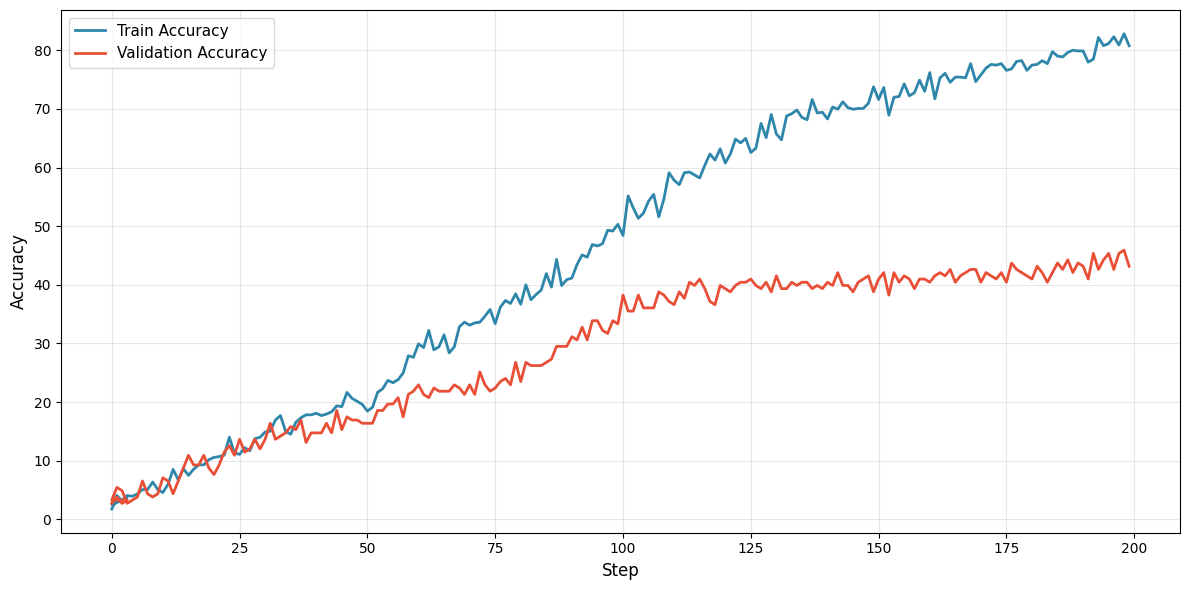

In [59]:
"""
Many experimentations were tried, and can be found in the Git history.
One of them is this:
To prevent overfitting, we are using early stoppage by saving the best validation accuracy.
We reduced the model complexity from 512,256 hidden nodes and 2 layers of LSTMs to 64,32 hidden nodes and 1 layer of LSTMs.
However, this didn't result in any significant improvement in overfitting.
"""

show_training("/content/drive/MyDrive/Intro_2_DL/runs/experiment_wlasl50.small_model")

In [ ]:
"""
Another experimentation that was tried was changing the augmentations to a manual one.
"""

"""
List of failed experimentations:
- 3D + CNN + LSTM
- Timesformer
- SlowFast
- High epochs
"""

## 10. Evaluation and Visualization


In [ ]:
# %pip install tensorboard matplotlib --quiet

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=/content/drive/MyDrive/Intro_2_DL/runs

In [52]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
def load_model(model, model_path):
  checkpoint = torch.load(model_path)
  model.load_state_dict(checkpoint['model_state_dict'])

load_model(model10, "/content/drive/MyDrive/Intro_2_DL/2d_cnn_lstm_wlasl10_final.pth")

Available scalar tags: ['Loss/Train', 'Loss/Validation', 'Accuracy/Train', 'Accuracy/Validation', 'Hyperparameters/Learning_Rate']


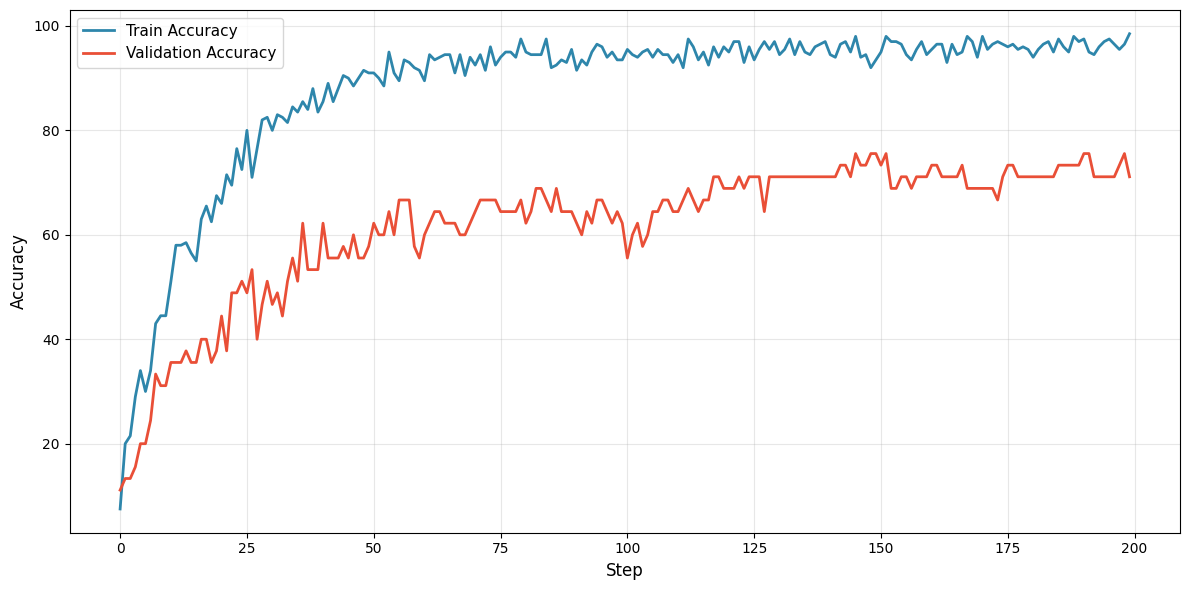

In [55]:

show_training()

In [34]:
# Load best model and evaluate on test set
checkpoint = torch.load('/content/drive/MyDrive/Intro_2_DL/2d_cnn_lstm_wlasl50_final.pth')
model50.load_state_dict(checkpoint['model_state_dict'])

_, _, test_loader = train_val_test_split(classes=10)
criterion = nn.CrossEntropyLoss()


test_loss, test_acc = evaluate(model50, test_loader, criterion, device)
print(f"\nTest Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")



Will download: True
Downloaded at path:  /kaggle/input/wlasl2000-resized
Limiting dataset to top 10 classes.
Will download: True
Downloaded at path:  /kaggle/input/wlasl2000-resized
Limiting dataset to top 10 classes.
Will download: True
Downloaded at path:  /kaggle/input/wlasl2000-resized
Limiting dataset to top 10 classes.
Number of training samples: 200
Number of validation samples: 45
Number of test samples: 35
Number of classes: 10


Evaluating: 100%|██████████| 2/2 [00:03<00:00,  1.75s/it]


Test Results:
Test Loss: 2.4415
Test Accuracy: 45.71%


In [ ]:
from IPython.display import Video

Video("/content/test.mp4", embed=True)

## 11. Attention Visualization

Visualize which frames the model attends to most when making predictions.


In [36]:
import matplotlib.pyplot as plt


def visualize_attention(model, frames, true_label, label_map, device):
    """Visualize attention weights over video frames."""
    model.eval()

    # Get reverse label map
    idx_to_label = {v: k for k, v in label_map.items()}

    with torch.no_grad():
        # Add batch dimension
        frames_batch = frames.unsqueeze(0).to(device)

        # Get predictions and attention weights
        logits, attention_weights = model(frames_batch, return_attention=True)
        pred_label = torch.argmax(logits, dim=1).item()
        attention = attention_weights[0].cpu().numpy()

    # Create visualization
    num_frames = frames.shape[0]
    fig, axes = plt.subplots(2, num_frames, figsize=(2 * num_frames, 6))

    # Denormalize frames for visualization
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    for i in range(num_frames):
        frame = frames[i].cpu()
        frame = frame * std + mean
        frame = frame.clamp(0, 1).permute(1, 2, 0).numpy()

        # Frame image
        axes[0, i].imshow(frame)
        axes[0, i].set_title(f"Frame {i+1}")
        axes[0, i].axis('off')

        # Attention weight bar
        axes[1, i].bar([0], [attention[i]], color='blue', alpha=0.7)
        axes[1, i].set_ylim(0, max(attention) * 1.2)
        axes[1, i].set_title(f"{attention[i]:.3f}")
        axes[1, i].axis('off')

    plt.suptitle(
        f"True: {idx_to_label.get(true_label, true_label)} | "
        f"Predicted: {idx_to_label.get(pred_label, pred_label)}",
        fontsize=14
    )
    plt.tight_layout()
    plt.show()

    return pred_label, attention


Will download: True
Downloaded at path:  /kaggle/input/wlasl2000-resized
Limiting dataset to top 10 classes.
Will download: True
Downloaded at path:  /kaggle/input/wlasl2000-resized
Limiting dataset to top 10 classes.
Will download: True
Downloaded at path:  /kaggle/input/wlasl2000-resized
Limiting dataset to top 10 classes.
Number of training samples: 200
Number of validation samples: 45
Number of test samples: 35
Number of classes: 10


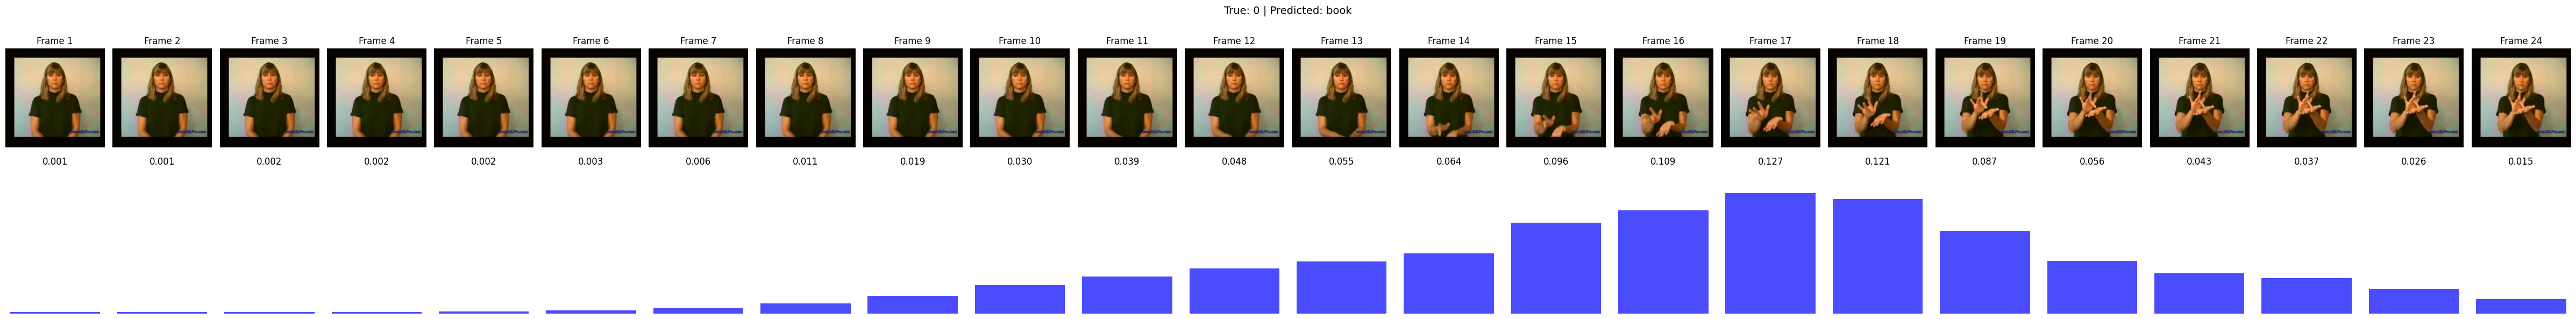

In [37]:
_, _, test = train_val_test_split(classes=10)


# Visualize attention for a sample from the test set
sample_idx = 0
frames, label = test.dataset[sample_idx]
pred, attn = visualize_attention(model50, frames, label, test.dataset.label_map, device)


# 10.5. Prediction grid + testing results


In [41]:

import torch
import random
import matplotlib.pyplot as plt
import numpy as np
from torch.cuda.amp import autocast


def test_report(model, dataloader, criterion, device):
    """Evaluate the model on a dataset, including Top-1, Top-5, and Top-10 accuracy."""
    model.eval()
    running_loss = 0.0

    correct_top1 = 0
    correct_top5 = 0
    correct_top10 = 0

    total = 0

    with torch.no_grad():
        for frames, labels in tqdm(dataloader, desc="Evaluating"):
            frames = frames.to(device)
            labels = labels.to(device)
            batch_size = labels.size(0)

            with autocast():
                outputs = model(frames)
                loss = criterion(outputs, labels)

            running_loss += loss.item() * batch_size
            total += batch_size

            # ---- Top-1 accuracy ----
            _, pred_top1 = outputs.max(dim=1)
            correct_top1 += (pred_top1 == labels).sum().item()

            # ---- Top-5 & Top-10 accuracy ----
            # Get top-k indices
            top5 = torch.topk(outputs, k=5, dim=1).indices
            top10 = torch.topk(outputs, k=10, dim=1).indices

            # Compare with labels
            labels_expanded = labels.view(-1, 1)

            correct_top5 += (top5 == labels_expanded).any(dim=1).sum().item()
            correct_top10 += (top10 == labels_expanded).any(dim=1).sum().item()

    epoch_loss = running_loss / total
    top1_acc = 100 * correct_top1 / total
    top5_acc = 100 * correct_top5 / total
    top10_acc = 100 * correct_top10 / total

    return epoch_loss, top1_acc, top5_acc, top10_acc

load_model(model10, "/content/drive/MyDrive/Intro_2_DL/2d_cnn_lstm_wlasl10_final.pth")

load_model(model50, "/content/drive/MyDrive/Intro_2_DL/2d_cnn_lstm_wlasl50_final.pth")

load_model(model100, "/content/drive/MyDrive/Intro_2_DL/2d_cnn_lstm_wlasl100_final.pth")
_, _, loader10 = train_val_test_split(classes=10)
_, _, loader50 = train_val_test_split(classes=50)
_, _, loader100 = train_val_test_split(classes=100)
result10 = test_report(model10, loader10, criterion, device)
result50 = test_report(model50, loader50, criterion, device)
result100 = test_report(model100, loader100, criterion, device)

from tabulate import tabulate

data = [
    ("WLASL10",*result10),
    ("WLASL50",*result50),
    ("WLASL100",*result100)
]
headers = ["Model", "Loss", "Top-1", "Top-5", "Top-10"]
print(tabulate(data, headers=headers, tablefmt="grid"))

Will download: True
Downloaded at path:  /kaggle/input/wlasl2000-resized
Limiting dataset to top 10 classes.
Will download: True
Downloaded at path:  /kaggle/input/wlasl2000-resized
Limiting dataset to top 10 classes.
Will download: True
Downloaded at path:  /kaggle/input/wlasl2000-resized
Limiting dataset to top 10 classes.
Number of training samples: 200
Number of validation samples: 45
Number of test samples: 35
Number of classes: 10
Will download: True
Downloaded at path:  /kaggle/input/wlasl2000-resized
Limiting dataset to top 50 classes.
Will download: True
Downloaded at path:  /kaggle/input/wlasl2000-resized
Limiting dataset to top 50 classes.
Will download: True
Downloaded at path:  /kaggle/input/wlasl2000-resized
Limiting dataset to top 50 classes.
Number of training samples: 785
Number of validation samples: 183
Number of test samples: 143
Number of classes: 50
Will download: True
Downloaded at path:  /kaggle/input/wlasl2000-resized
Limiting dataset to top 100 classes.
Will d

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]/tmp/ipython-input-1457823240.py:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.26it/s]

+----------+---------+---------+---------+----------+
| Model    |    Loss |   Top-1 |   Top-5 |   Top-10 |
+==========+=========+=========+=========+==========+
| WLASL10  | 1.55356 | 57.1429 | 82.8571 | 100      |
+----------+---------+---------+---------+----------+
| WLASL50  | 2.66935 | 39.8601 | 60.8392 |  71.3287 |
+----------+---------+---------+---------+----------+
| WLASL100 | 2.9997  | 35.6589 | 57.7519 |  66.2791 |
+----------+---------+---------+---------+----------+


{0: 'book', 1: 'drink', 2: 'computer', 3: 'before', 4: 'chair', 5: 'go', 6: 'clothes', 7: 'who', 8: 'candy', 9: 'cousin', 10: 'deaf', 11: 'fine', 12: 'help', 13: 'no', 14: 'thin', 15: 'walk', 16: 'year', 17: 'yes', 18: 'all', 19: 'black', 20: 'cool', 21: 'finish', 22: 'hot', 23: 'like', 24: 'many', 25: 'mother', 26: 'now', 27: 'orange', 28: 'table', 29: 'thanksgiving', 30: 'what', 31: 'woman', 32: 'bed', 33: 'blue', 34: 'bowling', 35: 'can', 36: 'dog', 37: 'family', 38: 'fish', 39: 'graduate', 40: 'hat', 41: 'hearing', 42: 'kiss', 43: 'language', 44: 'later', 45: 'man', 46: 'shirt', 47: 'study', 48: 'tall', 49: 'white', 50: 'wrong', 51: 'accident', 52: 'apple', 53: 'bird', 54: 'change', 55: 'color', 56: 'corn', 57: 'cow', 58: 'dance', 59: 'dark', 60: 'doctor', 61: 'eat', 62: 'enjoy', 63: 'forget', 64: 'give', 65: 'last', 66: 'meet', 67: 'pink', 68: 'pizza', 69: 'play', 70: 'school', 71: 'secretary', 72: 'short', 73: 'time', 74: 'want', 75: 'work', 76: 'africa', 77: 'basketball', 78: 'b

/tmp/ipython-input-1984753564.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


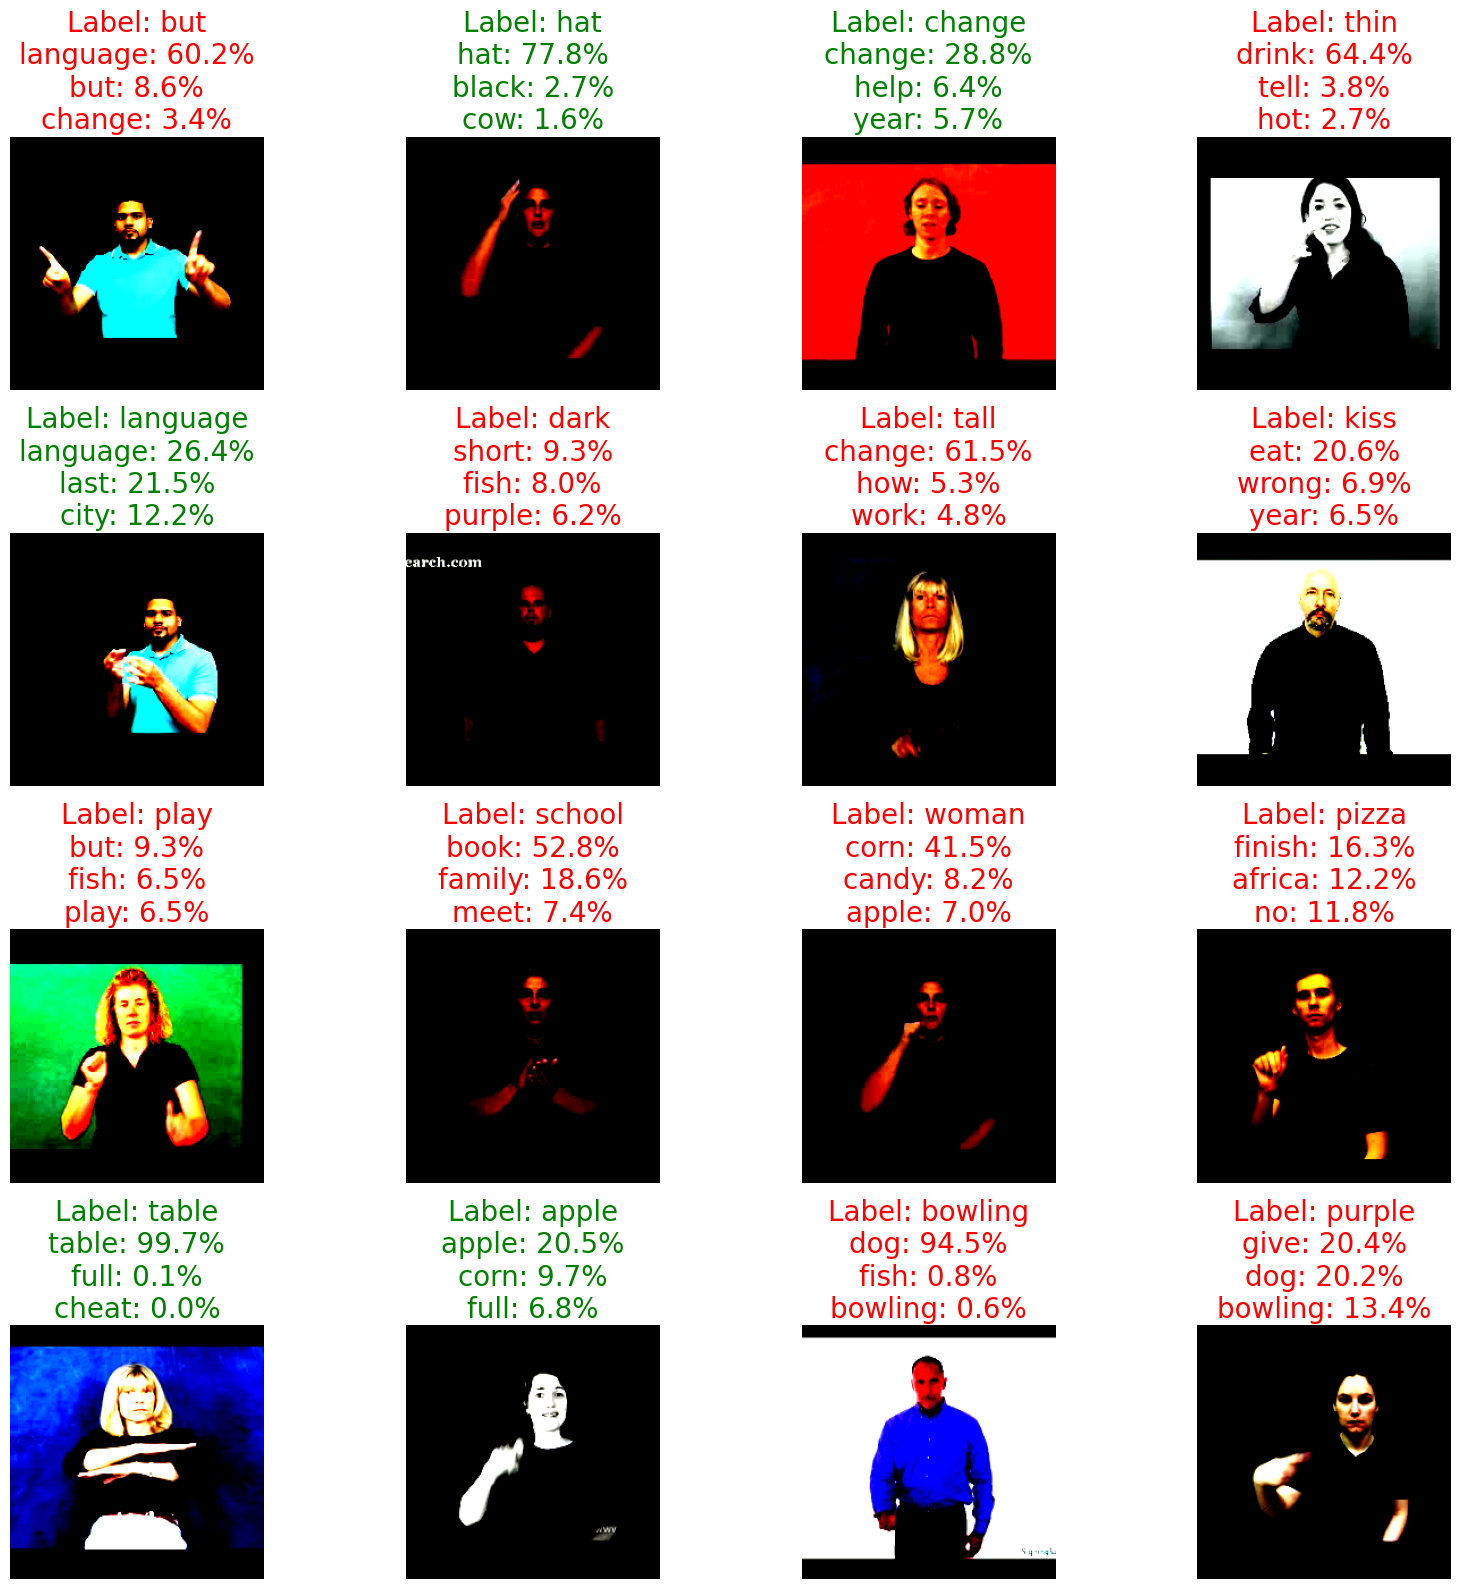

In [42]:
def show_evaluation_grid(model, dataloader, class_names, device, N=3, M=4):
    """
    Show an NxM grid of middle frames from random samples in the dataloader
    along with top-5 predicted classes. Title is GREEN if prediction is correct,
    RED if incorrect.
    """
    model.eval()

    # Collect all samples for random selection
    all_samples = []
    for data, labels in dataloader:
        for i in range(data.size(0)):
            all_samples.append((data[i], labels[i]))

    total_samples = N * M
    chosen = random.sample(all_samples, total_samples)

    fig, axes = plt.subplots(N, M, figsize=(M * 4, N * 4))
    axes = axes.flatten()

    with torch.no_grad():
        for idx, (frames, label) in enumerate(chosen):
            ax = axes[idx]

            T = frames.shape[0]
            mid_frame = frames[T // 2]

            input_frames = frames.unsqueeze(0).to(device)
            label = label.to(device)

            with autocast():
                outputs = model(input_frames)
                probs = torch.softmax(outputs, dim=1)

            top5_prob, top5_idx = torch.topk(probs, 5, dim=1)
            top5_prob = top5_prob.squeeze().cpu().numpy()
            top5_idx = top5_idx.squeeze().cpu().numpy()

            top1 = top5_idx[0]

            pred_text = "\n".join(
                [f"{class_names[top5_idx[i]]}: {top5_prob[i]*100:.1f}%"
                 for i in range(3)]
            )

            img = mid_frame.permute(1, 2, 0).cpu().numpy()
            img = np.clip(img, 0, 1)

            ax.imshow(img)

            correct = (top1 == label.item())
            title_color = "green" if correct else "red"

            ax.set_title(
                f"Label: {class_names[label.item()]}\n{pred_text}",
                fontsize=20,
                color=title_color
            )
            ax.axis("off")

    plt.tight_layout()
    plt.show()

class_map = { v:k for k,v in loader100.dataset.label_map.items() }
print(class_map)
show_evaluation_grid(model100, loader100, class_map, device, N=4, M=4)

## 11. Inference Function


In [43]:
def predict_video(model, video_path, transform, num_frames, label_map, device):
    """Predict the sign language class for a video file."""
    model.eval()

    # Get reverse label map
    idx_to_label = {v: k for k, v in label_map.items()}

    # Decode video
    decoder = VideoDecoder(video_path)
    frames = transform(decoder[:])

    # Predict
    with torch.no_grad():
        frames_batch = frames.unsqueeze(0).to(device)
        logits, attention = model(frames_batch, return_attention=True)
        probabilities = F.softmax(logits, dim=1)
        pred_idx = torch.argmax(logits, dim=1).item()
        confidence = probabilities[0, pred_idx].item()
        # print(probabilities[0])
        confidence_map = {k:probabilities[0][v] for k, v in label_map.items()}

    predicted_label = idx_to_label.get(pred_idx, f"Unknown ({pred_idx})")

    return {
        'prediction': predicted_label,
        'confidence': confidence,
        'attention_weights': attention[0].cpu().numpy(),
        'all_probabilities': probabilities[0].cpu().numpy(),
        'confidence_map': confidence_map
    }


In [ ]:
# Example inference (uncomment and modify path to use)
result = predict_video(
    model=model100,
    video_path="/content/test3.mp4",
    transform=val_transform,
    num_frames=NUM_FRAMES,
    label_map=loader100.dataset.label_map,
    device=device
)
result

## 12. Save Final Model


In [ ]:
# Save complete model for deployment
torch.save({
    'model_state_dict': model.state_dict(),
    'label_map': train_dataset.label_map,
    'config': {
        'num_classes': NUM_CLASSES,
        'feature_dim': FEATURE_DIM,
        'hidden_dim': HIDDEN_DIM,
        'num_lstm_layers': NUM_LSTM_LAYERS,
        'num_frames': NUM_FRAMES,
        'dropout': DROPOUT
    }
}, 'sign2text_model_final.pth')

print("Model saved to sign2text_model_final.pth")
